In [130]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from collections import Counter

# BoTorch / GPyTorch 関連
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from mpl_toolkits.mplot3d import Axes3D  # 必要に応じて

# Plot周りの設定
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
plt.rcParams["figure.dpi"] = 100  # 高解像度設定

In [131]:
def styblinski_tang(x, noise_std=0.00001):
    """
    x: shape (..., d) のテンソル（d>=5を仮定）
       目的関数の計算には最初の5次元のみを利用する。
    noise_std: ノイズの標準偏差
    """
    if torch.is_tensor(x):
        x_val = x[..., :5]  # shape (..., 5)
    else:
        x_val = torch.tensor(x[..., :5], dtype=torch.float32)
    result = 0.5 * torch.sum(x_val ** 4 - 16 * x_val ** 2 + 5 * x_val, dim=-1)
    noise = torch.randn_like(result) * noise_std
    return result + noise

In [132]:
class ECI_BO_Bandit:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, coordinate_ratio=0.5):
        dtype = torch.float
        self.num_arms = dim
        self.A = torch.eye(dim, dtype=dtype)
        self.b = torch.zeros(dim, dtype=dtype)
        self.objective_function = objective_function
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []
        self.arm_selection_history = []
        self.optimization_history = []
        self.saved_plot_files = []
        self.coordinate_ratio = coordinate_ratio
        self.sigma = 0.1
        self.L = 5.0
        self.lambda_reg = 1.0
        self.delta = 0.1
        self.S = 10.0
        self.selected_direction_history = []
        self.theta_history = []
        self.reward_history = []
        self.iteration_table_data = []
        self.direction_sum_abs = torch.zeros(dim, dtype=dtype)

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-5).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)
        self.update_model()
        posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.X[best_index]
        self.eval_history = [self.best_value] * self.n_initial

    def generate_arms(self):
        dtype = torch.float
        num_coord = int(math.floor(self.coordinate_ratio * self.dim))
        if num_coord > self.dim:
            num_coord = self.dim
        random_indices = np.random.choice(self.dim, num_coord, replace=False)
        coordinate_arms = []
        for idx in random_indices:
            e_i = torch.zeros(self.dim, dtype=dtype)
            e_i[idx] = 1.0
            coordinate_arms.append(e_i)
        coordinate_arms = torch.stack(coordinate_arms, dim=0) if len(coordinate_arms)>0 else torch.zeros(0, self.dim, dtype=dtype)
        num_random = self.dim - num_coord
        if num_random > 0:
            A_inv = torch.inverse(self.A)
            theta_current = (A_inv @ self.b).detach()
            probs = torch.softmax(torch.abs(theta_current), dim=0).cpu().numpy()
            random_arms = []
            for i in range(num_random):
                chosen_indices = np.random.choice(self.dim, 5, replace=False, p=probs)
                vec = torch.zeros(self.dim, dtype=dtype)
                vec[chosen_indices] = torch.randn(5, dtype=dtype)
                vec = vec / vec.norm()
                random_arms.append(vec)
            random_arms = torch.stack(random_arms, dim=0)
        else:
            random_arms = torch.zeros(0, self.dim, dtype=dtype)
        arms = torch.cat([coordinate_arms, random_arms], dim=0)
        return arms

    def select_arm(self, total_iterations):
        A_inv = torch.inverse(self.A)
        theta = A_inv @ self.b
        self.theta_history.append(theta.clone())
        p_values = []
        beta_t = self.sigma * math.sqrt(self.dim * math.log((1 + total_iterations * (self.L ** 2) / self.lambda_reg) / self.delta)) + math.sqrt(self.lambda_reg) * self.S
        for i in range(self.num_arms):
            x_arm = self.arms_features[i].view(-1, 1)
            mean = (theta.view(1, -1) @ x_arm).item()
            var = (x_arm.t() @ A_inv @ x_arm).item()
            ucb = mean + beta_t * math.sqrt(var)
            p_values.append(ucb)
        return int(np.argmax(p_values))

    def optimize(self):
        self.initialize()
        self.optimization_history = []
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        self.update_model()
        while n < self.n_max:
            self.arms_features = self.generate_arms()
            selected_arm = self.select_arm(total_iterations)
            self.arm_selection_history.append(selected_arm)
            direction = self.arms_features[selected_arm]
            self.selected_direction_history.append(direction.clone())
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
            def eci_func(x):
                x_scalar = x.squeeze(-1).squeeze(-1)
                full_x = self.best_point.clone().unsqueeze(0)
                full_x = full_x + x_scalar[:, None] * direction
                full_x = full_x.unsqueeze(1)
                return ei(full_x)
            one_d_bounds = torch.tensor([[-5.0], [5.0]], dtype=dtype)
            candidate, acq_value = optimize_acqf(
                eci_func,
                one_d_bounds,
                q=1,
                num_restarts=10,
                raw_samples=100,
            )
            new_x = self.best_point.clone() + candidate.squeeze() * direction
            new_x = torch.clamp(new_x, self.bounds[0], self.bounds[1])
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)
            reward = max(0, self.best_value - new_y.item())
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.optimization_history.append(new_x.clone())
            x_arm = direction.view(-1, 1)
            self.A = self.A + x_arm @ x_arm.t()
            reward = math.log(1 + reward)
            self.reward_history.append(reward)
            self.b = self.b + reward * direction
            self.update_model()
            posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.X[best_index]
            self.eval_history.append(self.best_value)
            self.direction_sum_abs += direction.abs()
            kernel = self.model.covar_module
            lengthscale = kernel.base_kernel.lengthscale.detach().cpu().numpy()
            outputscale = kernel.outputscale.detach().cpu().numpy()
            iteration_data = {
                "iteration": total_iterations,
                "x": new_x.detach().cpu().numpy(),
                "y": new_y.item(),
                "best_value": self.best_value,
                "candidate_parameta": candidate.squeeze(),
                "kernel_lengthscale": lengthscale,
                "kernel_outputscale": outputscale,
                "reward": reward,
            }
            self.iteration_table_data.append(iteration_data)
            n += 1
            total_iterations += 1
        return self.best_point, self.best_value

In [133]:
class REMBO_BO:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, d_emb=5):
        """
        d_emb: 埋め込み次元
        """
        dtype = torch.float
        self.objective_function = objective_function
        self.full_dim = dim
        self.d_emb = d_emb
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        # REMBOでは高次元空間から低次元へ射影するランダム行列Aを生成
        self.A = torch.randn(dim, d_emb, dtype=dtype)
        # 高次元上での評価データ
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []

    def project(self, z):
        # 低次元変数 z (shape: (..., d_emb)) を高次元に射影: x = A z
        x = z @ self.A.t()
        # boundsに合わせてクリップ
        x = torch.clamp(x, self.bounds[0], self.bounds[1])
        return x

    def update_model(self, Z, Y):
        # 低次元上でのGPモデルを更新
        kernel = ScaleKernel(RBFKernel(ard_num_dims=Z.shape[-1]), noise_constraint=1e-5).to(Z)
        self.model = SingleTaskGP(Z, Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        # REMBOの初期点: 低次元上で一様サンプル
        Z_init = torch.rand(self.n_initial, self.d_emb) * 10 - 5  # [-5,5]の範囲
        X_init = self.project(Z_init)
        y_val = self.objective_function(X_init)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)
        self.Z = Z_init
        self.X = X_init
        self.update_model(self.Z, self.Y)
        posterior_mean = self.model.posterior(self.Z).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.project(self.Z[best_index].unsqueeze(0)).squeeze(0)
        self.eval_history = [self.best_value] * self.n_initial

    def optimize(self):
        self.initialize()
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        while n < self.n_max:
            # 獲得関数 EI を低次元上で定義
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
            bounds_z = torch.tensor([[-5.0]] * self.d_emb + [[5.0]] * self.d_emb, dtype=dtype)
            bounds_tensor = torch.tensor([[-5.0] * self.d_emb, [5.0] * self.d_emb], dtype=dtype)
            candidate, acq_value = optimize_acqf(
                ei,
                bounds=bounds_tensor,
                q=1,
                num_restarts=10,
                raw_samples=100,
            )
            # 低次元候補から高次元点に射影
            new_z = candidate.squeeze()
            new_x = self.project(new_z.unsqueeze(0)).squeeze(0)
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)
            # データ更新（低次元・高次元共に）
            self.Z = torch.cat([self.Z, new_z.unsqueeze(0)])
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.update_model(self.Z, self.Y)
            posterior_mean = self.model.posterior(self.Z).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.project(self.Z[best_index].unsqueeze(0)).squeeze(0)
            self.eval_history.append(self.best_value)
            n += 1
            total_iterations += 1
        return self.best_point, self.best_value


In [134]:
class Dropout_BO:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, dropout_rate=0.5):
        """
        dropout_rate: 最適化で動かす次元の割合 (例: 0.5なら半分の次元)
        """
        dtype = torch.float
        self.objective_function = objective_function
        self.full_dim = dim
        self.dropout_rate = dropout_rate
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-5).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)
        self.update_model()
        posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.X[best_index]
        self.eval_history = [self.best_value] * self.n_initial

    def optimize(self):
        self.initialize()
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        while n < self.n_max:
            num_vars = int((1 - self.dropout_rate) * self.full_dim)
            # numpy 配列から torch のインデックスに変換
            selected_dims_np = np.sort(np.random.choice(self.full_dim, num_vars, replace=False))
            selected_dims = torch.tensor(selected_dims_np, dtype=torch.long, device=self.X.device)
            def dropout_ei(x):
                # x: shape (batch_size, 1) または (batch_size, 1, 1)
                x_scalar = x.squeeze(-1).squeeze(-1)  # shape: (batch_size,)
                # self.best_point を detach して再利用しないようにする
                best_point = self.best_point.clone().detach()  # shape: (full_dim,)
                full_x = best_point.unsqueeze(0).expand(x_scalar.shape[0], -1)  # shape: (batch_size, full_dim)
                full_x[:, selected_dims] = full_x[:, selected_dims] + x_scalar.unsqueeze(1)
                # ExpectedImprovement の入力は [batch_size, q, d] (ここで q=1)
                full_x = full_x.unsqueeze(1)  # shape: (batch_size, 1, full_dim)
                ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
                return ei(full_x)
            one_d_bounds = torch.tensor([[-5.0], [5.0]], dtype=dtype)
            candidate, acq_value = optimize_acqf(
                dropout_ei,
                one_d_bounds,
                q=1,
                num_restarts=10,
                raw_samples=100,
            )
            new_x = self.best_point.clone()
            new_x[selected_dims] = new_x[selected_dims] + candidate.squeeze()
            new_x = torch.clamp(new_x, self.bounds[0], self.bounds[1])
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.update_model()
            posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.X[best_index]
            self.eval_history.append(self.best_value)
            n += 1
            total_iterations += 1
        return self.best_point, self.best_value


In [135]:
class ECI_BO:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim):
        dtype = torch.float
        self.objective_function = objective_function
        self.dim = dim
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.dim), noise_constraint=1e-5).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)
        self.update_model()
        posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.X[best_index].view(-1)  # force 1D
        self.eval_history = [self.best_value] * self.n_initial

    def optimize(self):
        self.initialize()
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        while n < self.n_max:
            best_improv = float('inf')
            best_candidate = None
            best_axis = None
            for axis in range(self.dim):
                def axis_ei(x):
                    # x: candidate offset; force it to be 1D
                    x_scalar = x.view(-1)  # shape: [batch_size]
                    bp = self.best_point.view(-1)  # shape: [d]
                    batch_size = int(x_scalar.shape[0])
                    d = int(bp.shape[0])
                    # Use repeat to form a [batch_size, d] tensor
                    full_x = bp.unsqueeze(0).repeat(batch_size, 1)
                    # Add offset on the selected axis
                    full_x[:, axis] = full_x[:, axis] + x_scalar
                    full_x = full_x.unsqueeze(1)  # shape: [batch_size, 1, d]
                    ei_val = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
                    return ei_val(full_x)
                one_d_bounds = torch.tensor([[-5.0], [5.0]], dtype=dtype)
                candidate, acq_value = optimize_acqf(
                    axis_ei,
                    one_d_bounds,
                    q=1,
                    num_restarts=5,
                    raw_samples=50,
                )
                val = axis_ei(candidate)
                if val.item() < best_improv:
                    best_improv = val.item()
                    best_candidate = candidate.view(-1)  # force 1D
                    best_axis = axis
            new_x = self.best_point.view(-1).clone()
            new_x[best_axis] = new_x[best_axis] + best_candidate
            new_x = torch.clamp(new_x, self.bounds[0], self.bounds[1])
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.update_model()
            posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.X[best_index].view(-1)
            self.eval_history.append(self.best_value)
            n += 1
            total_iterations += 1
        return self.best_point, self.best_value

In [136]:
class SAASBO_BO:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim):
        dtype = torch.float
        self.objective_function = objective_function
        self.dim = dim
        self.bounds = bounds.to(dtype=dtype)
        self.n_initial = n_initial
        self.n_max = n_max
        self.X = X.to(dtype=dtype)
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []

    def update_model(self):
        # ここではシンプルにARDカーネルを用いる（実際はスパース性を誘導する事前などが必要だが、ここでは簡易版）
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.dim), noise_constraint=1e-5).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        y_val = self.objective_function(self.X)
        if y_val.dtype != torch.float:
            y_val = y_val.float()
        self.Y = y_val.unsqueeze(-1)
        self.update_model()
        posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
        best_index = posterior_mean.argmin()
        self.best_value = posterior_mean[best_index].item()
        self.best_point = self.X[best_index]
        self.eval_history = [self.best_value] * self.n_initial

    def optimize(self):
        self.initialize()
        n = self.n_initial
        total_iterations = 1
        dtype = torch.float
        while n < self.n_max:
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
            # full-dimension の bounds を使用する
            candidate, acq_value = optimize_acqf(
                lambda x: ei(x),
                bounds=self.bounds,  # ここが修正ポイントです
                q=1,
                num_restarts=10,
                raw_samples=100,
            )
            new_x = self.best_point.clone() + candidate.squeeze()  # シンプルな更新
            new_x = torch.clamp(new_x, self.bounds[0], self.bounds[1])
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1).to(dtype=dtype)
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])
            self.update_model()
            posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            best_index = posterior_mean.argmin()
            self.best_value = posterior_mean[best_index].item()
            self.best_point = self.X[best_index].view(-1)
            self.eval_history.append(self.best_value)
            n += 1
            total_iterations += 1
        return self.best_point, self.best_value

In [137]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]

  0%|          | 0/5 [elapsed: 00:00 remaining: ?]

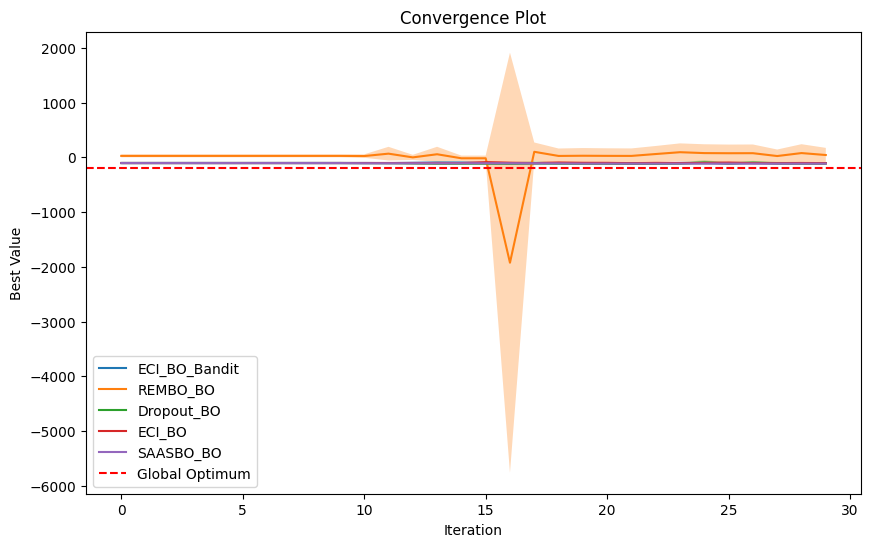

In [138]:
if __name__ == "__main__":
    # パラメータ設定
    dim = 50
    bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
    n_initial = 10
    n_iter = 30
    n_runs = 5

    # 各アルゴリズムの履歴を保持するリスト
    results = {"ECI_BO_Bandit": [], "REMBO_BO": [], "Dropout_BO": [], "ECI_BO": [], "SAASBO_BO": []}

    try:
        with tqdm.notebook.tqdm(total=n_runs, bar_format=TQDM_BAR_FORMAT) as pbar:
            with io.capture_output() as captured:
                for run in range(n_runs):
                    X_init = generate_initial_points(n_initial, dim, bounds)
                    algo1 = ECI_BO_Bandit(
                        X_init.clone(),
                        objective_function=styblinski_tang,
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim,
                        coordinate_ratio=0.8
                    )
                    algo2 = REMBO_BO(
                        X_init.clone(),
                        objective_function=styblinski_tang,
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim,
                        d_emb=5
                    )
                    algo3 = Dropout_BO(
                        X_init.clone(),
                        objective_function=styblinski_tang,
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim,
                        dropout_rate=0.5
                    )
                    algo4 = ECI_BO(
                        X_init.clone(),
                        objective_function=styblinski_tang,
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim
                    )
                    algo5 = SAASBO_BO(
                        X_init.clone(),
                        objective_function=styblinski_tang,
                        bounds=bounds,
                        n_initial=n_initial,
                        n_max=n_iter,
                        dim=dim
                    )

                    best_x1, best_f1 = algo1.optimize()
                    best_x2, best_f2 = algo2.optimize()
                    best_x3, best_f3 = algo3.optimize()
                    best_x4, best_f4 = algo4.optimize()
                    best_x5, best_f5 = algo5.optimize()

                    results["ECI_BO_Bandit"].append(algo1.eval_history)
                    results["REMBO_BO"].append(algo2.eval_history)
                    results["Dropout_BO"].append(algo3.eval_history)
                    results["ECI_BO"].append(algo4.eval_history)
                    results["SAASBO_BO"].append(algo5.eval_history)

                    pbar.update(1)
    except subprocess.CalledProcessError:
        print(captured)
        raise

    plt.figure(figsize=(10,6))
    for key in results.keys():
        # 各試行の評価履歴のリスト results[key] の最小長さを求める
        min_length = min(len(hist) for hist in results[key])
        # 各履歴を最小長さに切り詰める
        data = np.array([hist[:min_length] for hist in results[key]])
        x_axis = np.arange(min_length)
        mean_history = data.mean(axis=0)
        std_history = data.std(axis=0)
        plt.plot(x_axis, mean_history, label=key)
        plt.fill_between(x_axis, mean_history - std_history, mean_history + std_history, alpha=0.3)
    global_optimum = -39.16599 * 5  # 5次元最適値
    plt.axhline(y=global_optimum, color='r', linestyle='--', label="Global Optimum")
    plt.xlabel("Iteration")
    plt.ylabel("Best Value")
    plt.title("Convergence Plot")
    plt.legend()
    plt.show()
